# Blame and actual causality

**Preceding notebooks**

- [Actual Causality: the modified Halpern-Pearl definition]() TODO add link

- [Responsibility and actual causality]() TODO add link

**Summary**

We use the causal-model based explication of responsibility by J. Halpern (*Actual Causality, MIT Press, 2016), explained in a previous notebook to follow Halpern's explication of blame in terms of responsibility.

**Outline:**

[Intuitions](##intuitions)
    
[Formalization](#formalization)

[Implementation](#implementation)

[Examples](#examples)

- [Comments on example selection](#comments-on-example-selection)
  
- [Voting](#voting)

- [Stone-throwing](#stone-throwing)

- [Firing squad](#firing-squad)


## Intuitions

Blame assigned to agents, on this approach, depends on their epistemic state - if an agent had no reason to believe that performing a given action would lead to a given outcome, they should not be blamed for this action even if this outcome came about. (They might be blamed for not performing their epistemic duties in properly finding out whether the outcome would come about, but that is another action that the agent might still be blamed for). Blame, on this approach, is the agent's expected responsibility for a given outcome, relative to the agent's probability distribution over possible causal models (including states of the exogenous variables).

## Formalization

Say the epistemic state of an agent is represented as $\langle K, \Pr\rangle$, where $K$ is a set of causal settings, and $Pr$ is a probability distribution over $K$, representing the agent's uncertainty. Then the degree of blame of $X=x$ for $\varphi$ relative to $\langle K, \Pr\rangle$ is $\sum_{\langle M, \vec{u}\rangle \in K} dr\left( \langle M, \vec{u}\rangle, X=x, \varphi\right)Pr\left(\langle M, \vec{u}\rangle\right)$, where $dr$ is the degree of responsibility of $X=x$ for $\varphi$ in $\langle M, \vec{u}\rangle$, as defined in a previous notebook TODO add link

## Implementation

Here we simply re-use the implementations of actual causality and responsibility from the previous notebooks. All that remains is the calculation of expected values.

In [1]:
import functools

import numpy as np

import torch
from typing import Dict, List, Optional,  Union, Callable

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pyro
import pyro.distributions as dist

import random

import pyro
import pyro.distributions as dist
from chirho.indexed.ops import IndexSet, gather, indices_of, scatter
from chirho.interventional.handlers import do
from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual, Preemptions, BiasedPreemptions
from chirho.observational.handlers import condition

In [2]:
class HalpernPearlModifiedApproximate:

    def __init__(
        self, 
        model: Callable,
        antecedents: Union[Dict[str, torch.Tensor], List[str]],
        outcome: str,
        witness_candidates: List[str],
        observations: Optional[Dict[str, torch.Tensor]],
        sample_size: int = 100,
        event_dim: int = 0
        ):
        
        self.model = model
        self.antecedents = antecedents
        self.outcome = outcome
        self.witness_candidates = witness_candidates
        self.nodes = antecedents + [outcome] + witness_candidates
        self.observations = observations
        self.sample_size = sample_size

        self.antecedents_dict = (
            self.antecedents if isinstance(self.antecedents, dict)
            else self.revert_antecedents(self.antecedents)
        )
    
        self.preemptions = {candidate: functools.partial(self.preempt_with_factual,
                                             antecedents = self.antecedents) for 
                                             candidate in self.witness_candidates}
        

    @staticmethod
    def revert_antecedents(antecedents: List[str]) -> Dict[str, Callable[[torch.Tensor], torch.Tensor]]:
        return {antecedent: (lambda v: 1 - v) for antecedent in antecedents}

    @staticmethod   
    def preempt_with_factual(value: torch.Tensor, *,
                          antecedents: List[str] = None, event_dim: int = 0):
    
        if antecedents is None:
            antecedents = []

        antecedents = [a for a in antecedents if a in indices_of(value, event_dim=event_dim)]

        factual_value = gather(value, IndexSet(**{antecedent: {0} for antecedent in antecedents}),
                                event_dim=event_dim)
            
        return scatter({
            IndexSet(**{antecedent: {0} for antecedent in antecedents}): factual_value,
            IndexSet(**{antecedent: {1} for antecedent in antecedents}): factual_value,
        }, event_dim=event_dim)
        
        
    def __call__(self, *args, **kwargs):
        with pyro.poutine.trace() as trace:
            with MultiWorldCounterfactual():
                with do(actions=self.antecedents_dict):
                    with Preemptions(actions = self.preemptions):
                        with pyro.condition(data={k: torch.as_tensor(v) for k, v in self.observations.items()}):
                            with pyro.plate("plate", self.sample_size):
                                self.consequent = self.model()[self.outcome]
                                self.intervened_consequent = gather(self.consequent, IndexSet(**{ant: {1} for ant in self.antecedents}))
                                self.observed_consequent = gather(self.consequent, IndexSet(**{ant: {0} for ant in self.antecedents}))
                                self.consequent_differs = self.intervened_consequent != self.observed_consequent   
                                pyro.factor("consequent_differs", torch.where(self.consequent_differs, torch.tensor(0.0), torch.tensor(-1e8)))
                            
        self.trace = trace.trace
        self.nodes_trace = {node: self.trace.nodes[node]['value'] for node in self.nodes}
        
        
         # slightly hacky solution for odd witness candidate sets
        if  isinstance(self.consequent_differs.squeeze().tolist(), bool):
            self.existential_but_for = self.consequent_differs.squeeze()
        else:
            #if (len(self.consequent_differs.squeeze().tolist() )>1):
            self.existential_but_for = any(self.consequent_differs.squeeze().tolist()                )  


        witness_dict = dict()
        if self.witness_candidates:
            witness_keys = ["__split_" + candidate for candidate in self.witness_candidates]
            witness_dict = {key: self.trace.nodes[key]['value']  for key in witness_keys}
            

        witness_dict['observed'] = self.observed_consequent.squeeze()
        witness_dict['intervened'] = self.intervened_consequent.squeeze()
        witness_dict['consequent_differs'] = self.consequent_differs.squeeze()

        # slightly hacky as above
        self.witness_df = pd.DataFrame(witness_dict) if self.witness_candidates else witness_dict

        if self.witness_candidates:
            self.witness_df['witness_size'] = self.witness_df[witness_keys].sum(axis = 1)
            satisfactory = self.witness_df[self.witness_df['consequent_differs'] == True]
            
        self.minimal_witness_size = satisfactory['witness_size'].min() if self.witness_candidates else 0
        self.responsibility_internal = 1/(len(self.antecedents) + self.minimal_witness_size)


In [3]:
class HalpernPearlResponsibilityApproximate:

    def __init__(
        self, 
        model: Callable,
        nodes: List,
        antecedent: str,
        outcome: str,
        observations: Dict[str, torch.Tensor], 
        runs_n: int 
    ):
        self.model = model
        self.nodes = nodes
        self.antecedent = antecedent
        self.outcome = outcome
        self.observations = observations
        self.runs_n = runs_n
        
        self.minimal_antecedents_cache = []
        self.antecedent_sizes = []
        self.existential_but_fors = []
        self.minimal_witness_sizes = []
        self.responsibilities = []
        self.HPMs = []

    def __call__(self):
        
        for step in range(1,self.runs_n):

            nodes = self.nodes
            if self.outcome in nodes:
                nodes.remove(self.outcome) 
            
            companion_size = random.randint(0,len(nodes))
            companion_candidates = random.sample(self.nodes, companion_size)
            witness_candidates = [node for node in self.nodes if 
                                node != self.antecedent and 
                                node != self.outcome and 
                                    node not in companion_candidates]

            HPM = HalpernPearlModifiedApproximate(
                model = self.model,
                antecedents = companion_candidates,
                outcome = self.outcome,
                witness_candidates = witness_candidates,
                observations = self.observations,
                sample_size = 1000)
            
            HPM()

            self.HPMs.append(HPM)


            if  HPM.existential_but_for:


                subset_in_cache = any([s.issubset(set(HPM.antecedents)) for s in self.minimal_antecedents_cache])
                if not subset_in_cache:
                    self.minimal_antecedents_cache.append(set(HPM.antecedents))

                    if self.antecedent in HPM.antecedents:
                        self.antecedent_sizes.append(len(HPM.antecedents))
                        self.existential_but_fors.append(HPM.existential_but_for)
                        self.minimal_witness_sizes.append(HPM.minimal_witness_size)
                        self.responsibilities.append(HPM.responsibility_internal)


        self.denumerators = [x + y for x, y in zip(self.antecedent_sizes, self.minimal_witness_sizes)]

        self.responsibilityDF = pd.DataFrame(
            {"existential_but_for": [bool(value) for value in self.existential_but_fors],
                "antecedent_size": self.antecedent_sizes, 
                "minimal_witness_size": self.minimal_witness_sizes,
                "denumerator": self.denumerators,
                "responsibility": self.responsibilities
            }
            )
        if len(self.responsibilityDF['existential_but_for']) == 0:
            self.responsibility = 0
        else:
            min_denumerator = min(self.responsibilityDF['denumerator'])
            self.responsibility = 1/min_denumerator

 

## Examples

### Comments on example selection

- **firing squad:**  in this case we illustrate that while responsibility will be solely with the single marksman who has the live bullet (see a previous notebook on responsibility), blame assignments will be proportionate to the probabilities. 
  
- **voters:** while Halpern only considered responsibility for an outcome if one votes (and suggests that blame can be calculated), we go somewhat further. We investigate the blame for an outcome assigned to a voter who decides not to vote. We also use this example to illustrate that the definition of responsibility in terms of node-counting is naive, as the same situation can easily be represented using models with different node counts, which will have impact on responsibility and blame calculations.

- **pollution:** Halpern describes expected responsibility calculations for four scenarios involving two companies dumping pollutants into a river. We go further and show how approximate blame calculations in a continuous case (involving uncertainties about the amounts of pollutant dumped by the companies and about the threshold sufficient for the fish to die).

### Firing squad

We already discuss responsibility assignment in this scenario in the responsibility notebook. There is a firing squad consisting of five excellent marksmen. Only one of them has a live bullet in his rifle and the rest have blanks. They shoot and the prisoner dies.The marksmen shoot at the prisoner and he dies. The only cause of the prisoner’s death is the marksman with the live bullet. We have already seen that marksman has degree of responsibility 1 for the death and all the others have degree of responsibility 0. Now we will see that if the marksmen completely do not know which of them has the live bullet, blame is nevertheless equally distributed between them.

In [4]:
def firing_squad_model():
    probs = pyro.sample("probs", dist.Dirichlet(torch.ones(5)))

    who_has_bullet = pyro.sample("who_has_bullet", dist.OneHotCategorical(probs))

    mark0 = pyro.deterministic("mark0", torch.tensor([who[0] for who in who_has_bullet]), event_dim=0)
    mark1 = pyro.deterministic("mark1", torch.tensor([who[1] for who in who_has_bullet]), event_dim=0)
    mark2 = pyro.deterministic("mark2", torch.tensor([who[2] for who in who_has_bullet]), event_dim=0)
    mark3 = pyro.deterministic("mark3", torch.tensor([who[3] for who in who_has_bullet]), event_dim=0)
    mark4 = pyro.deterministic("mark4", torch.tensor([who[4] for who in who_has_bullet]), event_dim=0)

    dead = pyro.deterministic("dead", mark0 + mark1 + mark2 + mark3 + 
                                mark4  > 0)
    
    return {"probs": probs,
            "mark0": mark0,
            "mark1": mark1,
            "mark2": mark2,

            "mark3": mark3,
            "mark4": mark4, 
            "dead": dead}

In [5]:
# assign weights to models
# and take the weighted average

pyro.set_rng_seed(102)

marksman0_responsibilities = []
for who in range(0,5):
    probs = torch.zeros(5)
    probs[who] = 1.0


    responsibility_marksmen_HPR = HalpernPearlResponsibilityApproximate(
        model = firing_squad_model,
        nodes = ["mark" + str(i) for i in range(0,5)],
        antecedent = "mark0", outcome = "dead",
        observations = {"probs": probs,},
                        runs_n=50)

    responsibility_marksmen_HPR()
    marksman0_responsibilities.append(responsibility_marksmen_HPR.responsibility)

weights = torch.full((5,), .2)

# if your pr(mark0) = i, 
# the blame in this case is i as well 

print(torch.dot(torch.tensor(marksman0_responsibilities), weights))

tensor(0.2000)


### Voters


The general phenomenon in the voting setup is this: if $a$ voted for and $b$ against, $a>b$, a voter voting for has degree of responsibility $\frac{1}{\lceil (a-b)/2\rceil}$. So much is in Halpern. Now let's go beyond this: what if you decide whether to vote and consider your blame if your candidate looses and you didn't vote? This is still a somewhat simplistic setup: eight other people are about to vote, each outcome among them you consider equally likely, and you consider the blame associated with you skipping the voting if your candidate fails. In the first model, we represent the number of other voters who voted the same way you would have voted by a single node; in the second model, we have a separate node for each voter. We will see that this shift in representation method results in quite a difference in blame assignment. This indicates that counting nodes is a rather crude method of responsibility- or blame-splitting.

In [6]:
def choose_to_vote_model():
    u_a = pyro.sample("u_a", dist.Categorical(logits=torch.ones(8)))
    u_skip = pyro.sample("u_skip", dist.Bernoulli(0.5))

    a = pyro.deterministic("a", u_a, event_dim=0)
    skip = pyro.deterministic("skip", u_skip, event_dim=0)

    result = pyro.deterministic("result", 
                            (a + 1 - skip) > torch.ceil(9 - skip)/2)

    return {"a": a, "against": 8-a, "voted": 1 - skip, "result": result}

In [7]:
# your skipping is not an actual cause if a=1

skipping1HPM = HalpernPearlModifiedApproximate(
    model = choose_to_vote_model,
    antecedents = ["skip"],
    outcome = "result",
    witness_candidates = ["a"],
    observations = dict(u_a=1.),
    sample_size = 100)

skipping1HPM()

skipping1HPM.existential_but_for

False

In [8]:
# but it is, if a = 4

skipping4HPM = HalpernPearlModifiedApproximate(
    model = choose_to_vote_model,
    antecedents = ["skip"],
    outcome = "result",
    witness_candidates = ["a"],
    observations = dict(u_a=4.),
    sample_size = 100)

skipping4HPM()

skipping4HPM.existential_but_for

True

In [9]:
# with this model responsibilities follow the same pattern

skipping1HPR = HalpernPearlResponsibilityApproximate(
    model = choose_to_vote_model,
    nodes = ["a", "skip"],
    antecedent = "skip", outcome = "result",
    observations = dict(u_a=1.), 
    runs_n=50
    )

skipping1HPR()
skipping1HPR.responsibility

0

In [10]:
pyro.set_rng_seed(102)
skipping4HPR = HalpernPearlResponsibilityApproximate(
    model = choose_to_vote_model,
    nodes = ["a", "skip"],
    antecedent = "skip", outcome = "result",
    observations = dict(u_a=4.), 
    runs_n=50
    )

skipping4HPR()
skipping4HPR.responsibility


1.0

In [11]:
# but now suppose we work with a different representation
# in which each voter has their own node

def choose_to_vote_wide_model():
    u_vote0 = pyro.sample("u_vote0", dist.Bernoulli(0.6))
    u_vote1 = pyro.sample("u_vote1", dist.Bernoulli(0.6))
    u_vote2 = pyro.sample("u_vote2", dist.Bernoulli(0.6))
    u_vote3 = pyro.sample("u_vote3", dist.Bernoulli(0.6))
    u_vote4 = pyro.sample("u_vote4", dist.Bernoulli(0.6))
    u_vote5 = pyro.sample("u_vote5", dist.Bernoulli(0.6))
    u_vote6 = pyro.sample("u_vote6", dist.Bernoulli(0.6))
    u_vote7 = pyro.sample("u_vote7", dist.Bernoulli(0.6))
    u_skip = pyro.sample("u_skip", dist.Bernoulli(0.5))

    vote0 = pyro.deterministic("vote0", u_vote0, event_dim=0)
    vote1 = pyro.deterministic("vote1", u_vote1, event_dim=0)
    vote2 = pyro.deterministic("vote2", u_vote2, event_dim=0)
    vote3 = pyro.deterministic("vote3", u_vote3, event_dim=0)
    vote4 = pyro.deterministic("vote4", u_vote4, event_dim=0)
    vote5 = pyro.deterministic("vote5", u_vote5, event_dim=0)
    vote6 = pyro.deterministic("vote6", u_vote6, event_dim=0)
    vote7 = pyro.deterministic("vote7", u_vote7, event_dim=0)
    skip = pyro.deterministic("skip", u_skip, event_dim=0)


    result = pyro.deterministic("result", vote0 + vote1 + vote2 + vote3 + 
                                 vote4 + vote5 + vote6 + vote7 + 1 - skip > 4)
    return {"result": result.float()}


In [12]:
# if a = 1, skipping is still not an actual cause

skipping_wide1HPM = HalpernPearlModifiedApproximate(
    model = choose_to_vote_wide_model,
    antecedents = ["skip"],
    outcome = "result",
    witness_candidates = [f"vote{i}" for i in range(0,8)],
    observations = dict(u_vote0=1., u_vote1=0., u_vote2=0.,
                        u_vote3=0., u_vote4=0., u_vote5=0,
                        u_vote6=0., u_vote7=0.),
    sample_size = 1000)

skipping_wide1HPM()
skipping_wide1HPM.existential_but_for


False

In [13]:
# if a = 4, skipping still is an actual cause

skipping_wide4HPM = HalpernPearlModifiedApproximate(
    model = choose_to_vote_wide_model,
    antecedents = ["skip"],
    outcome = "result",
    witness_candidates = [f"vote{i}" for i in range(0,8)],
    observations = dict(u_vote0=1., u_vote1=1., u_vote2=1.,
                        u_vote3=1., u_vote4=0., u_vote5=0,
                        u_vote6=0., u_vote7=0.),
    sample_size = 1000)

skipping_wide4HPM()
skipping_wide4HPM.existential_but_for


True

In [14]:
# if a = 1 your responsibility is now 1/4
# because if you voted for
# and three other voters changed their mind,
# the outcome would be different

skipping_wide1HPR = HalpernPearlResponsibilityApproximate(
    model = choose_to_vote_wide_model,
    nodes = [f"vote{i}" for i in range(0,8,)] + ["skip"],
    antecedent = "skip", outcome = "result",
    observations =  dict(u_vote0=1., u_vote1=0., u_vote2=0.,
                        u_vote3=0., u_vote4=0., u_vote5=0,
                        u_vote6=0., u_vote7=0.), 
    runs_n=500
    )

skipping_wide1HPR()
skipping_wide1HPR.responsibility

0.25

The above illustrates one reason why what Halpern called the naive definition of responsibility used in Halpern is properly so named: it is highly sensitive to modeling choices and needs to be improved. This is a story for another occasion. Meawhile, let's assume that the wide model is the intended one and see what can be said about blame for failure before the voting happens.

In [15]:
# for a>4 blame is zero as your candidate wins
# let's use the first model

pyro.set_rng_seed(1231)

skipping_responsibilities = []

for a in range(0,5):

    observations = dict(u_a=a)

    skipping_stepHPR = HalpernPearlResponsibilityApproximate(
    model = choose_to_vote_model,
    nodes = ["a", "skip"],
    antecedent = "skip", outcome = "result",
    observations =  observations, 
    runs_n=100
    )
    skipping_stepHPR()

    skipping_responsibilities.append(skipping_stepHPR.responsibility)

skipping_responsibilities

[0, 0, 0, 0, 1.0]

In [16]:
# for a>4 blame is zero as your candidate wins

pyro.set_rng_seed(1231)

skipping_responsibilities_wide = []

for a in range(0,5):

    observations = {"u_vote"+str(i): 1. if i < a else 0. for i in range(0,8)}

    skipping_wide_stepHPR = HalpernPearlResponsibilityApproximate(
    model = choose_to_vote_wide_model,
    nodes = [f"vote{i}" for i in range(0,8,)] + ["skip"],
    antecedent = "skip", outcome = "result",
    observations =  observations, 
    runs_n=100
    )
    skipping_wide_stepHPR()

    skipping_responsibilities_wide.append(skipping_wide_stepHPR.responsibility)

skipping_responsibilities_wide
# [0.2, 0.25, 0.3333333333333333, 0.3333333333333333, 1.0]

[0.2, 0.25, 0.3333333333333333, 0.3333333333333333, 1.0]

In [17]:
# assuming each value of a has probability 1/8
# the expected value of responsibility for failure 
# if you skip the voting

blame = sum([1/8 * resp for resp in skipping_responsibilities])
# 1/8

blame_wide = sum([1/8 * resp for resp in skipping_responsibilities_wide])
# approx. 0.264

print("blame in the first model:", blame, "blame in the second model:", blame_wide)


blame in the first model: 0.125 blame in the second model: 0.26458333333333334


### Pollution

In the original example, company A dumps either 0 or 100 kilograms of pollutant, company B dumps either 60 or 0 kilograms, and biologists determine that k kilograms of pollutant sufﬁce for the ﬁsh to die. 
One problematic case is was when k = 80 and both companies dump pollutants. In this case, only A is a cause of the ﬁsh dying according to the modiﬁed HP deﬁnition. We'll go a bit further: we consider a situation in which the amount that companies have to potentially dump and the threshold come from normal distributions. 


In [18]:
amount_A = 100
amount_B = 60

def pollution_model():
    u_A_dumps = pyro.sample("u_A_dumps", dist.Bernoulli(0.5))
    u_B_dumps = pyro.sample("u_B_dumps", dist.Bernoulli(0.5))
    u_k = pyro.sample("u_k", dist.Normal(80., 10.))

    A_dumps = pyro.deterministic("A_dumps", u_A_dumps, event_dim=0)
    B_dumps = pyro.deterministic("B_dumps", u_B_dumps, event_dim=0)
    k = pyro.deterministic("k", u_k, event_dim=0)

    total_pollution = pyro.deterministic("total_pollution",
                                          A_dumps * amount_A + B_dumps * amount_B)
    dead = pyro.deterministic("dead", total_pollution > k)

    return {"total_pollution": total_pollution, "k": k, "dead": dead}


In [19]:
# A an actual cause in the original scenario
# B not an actual cause in the original scenario
# set threshold to 80


pollution_strict_A_HPM = HalpernPearlModifiedApproximate(
    model = pollution_model,
    antecedents = ["A_dumps"],
    outcome = "dead",
    witness_candidates = ["B_dumps"],
    observations = dict(u_A_dumps=1., u_B_dumps=1., u_k=80.),
    sample_size = 5)

pollution_strict_B_HPM = HalpernPearlModifiedApproximate(
    model = pollution_model,
    antecedents = ["B_dumps"],
    outcome = "dead",
    witness_candidates = ["A_dumps"],
    observations = dict(u_A_dumps=1., u_B_dumps=1., u_k=80.),
    sample_size = 5)

pollution_strict_A_HPM()
pollution_strict_B_HPM()

print(
pollution_strict_A_HPM.existential_but_for,
pollution_strict_B_HPM.existential_but_for
)

True False


Moreover, $B$ is not even a part of an actual cause, as the only antecedent set containing it that satisfies the existential but-for condition is the one containing both `A_dumps` and `B_dumps`, but already the singleton containing `A_dumps` is an actual cause, so the two-element set fails to satisfy the minimality condition. So the responsibility of $B$ in this case is 0.

Let's see how uncertainty about $A$, $B$, and $k$ might propagate and allow for an estimation of actual causality probability and of blame.

In [20]:
A_causality = []
B_causality = []
A_responsibility = []
B_responsibility = []

steps = 100


for run in range(0,steps):

    amount_A = pyro.sample("amount_A", dist.Normal(100., 25.))
    amount_B = pyro.sample("amount_B", dist.Normal(60., 25.))


    def pollution_model():
        u_A_dumps = pyro.sample("u_A_dumps", dist.Bernoulli(0.5))
        u_B_dumps = pyro.sample("u_B_dumps", dist.Bernoulli(0.5))
        u_k = pyro.sample("u_k", dist.Normal(80., 10.))

        A_dumps = pyro.deterministic("A_dumps", u_A_dumps, event_dim=0)
        B_dumps = pyro.deterministic("B_dumps", u_B_dumps, event_dim=0)
        k = pyro.deterministic("k", u_k, event_dim=0)

        total_pollution = pyro.deterministic("total_pollution",
                                            A_dumps * amount_A + B_dumps * amount_B)
        dead = pyro.deterministic("dead", total_pollution > k)

        return {"total_pollution": total_pollution, "k": k, "dead": dead}


    pollution_A_HPM = HalpernPearlModifiedApproximate(
        model = pollution_model,
        antecedents = ["A_dumps"],
        outcome = "dead",
        witness_candidates = ["B_dumps"],
        observations = dict(u_A_dumps=1., u_B_dumps=1.),
        sample_size = 5)

    pollution_B_HPM = HalpernPearlModifiedApproximate(
        model = pollution_model,
        antecedents = ["B_dumps"],
        outcome = "dead",
        witness_candidates = ["A_dumps"],
        observations = dict(u_A_dumps=1., u_B_dumps=1.),
        sample_size = 5)


    pollution_A_HPR = HalpernPearlResponsibilityApproximate(
    model = pollution_model,
    nodes = ["A_dumps", "B_dumps"],
    antecedent = "A_dumps", outcome = "dead",
    observations =  dict(u_A_dumps=1., u_B_dumps=1.), 
    runs_n=50
    )

    pollution_B_HPR = HalpernPearlResponsibilityApproximate(
    model = pollution_model,
    nodes = ["A_dumps", "B_dumps"],
    antecedent = "B_dumps", outcome = "dead",
    observations =  dict(u_A_dumps=1., u_B_dumps=1.), 
    runs_n=50
    )


    pollution_A_HPM()
    pollution_B_HPM()

    pollution_A_HPR()
    pollution_B_HPR()

    A_causality.append(pollution_A_HPM.existential_but_for)
    B_causality.append(pollution_B_HPM.existential_but_for)
    A_responsibility.append(pollution_A_HPR.responsibility)
    B_responsibility.append(pollution_B_HPR.responsibility)



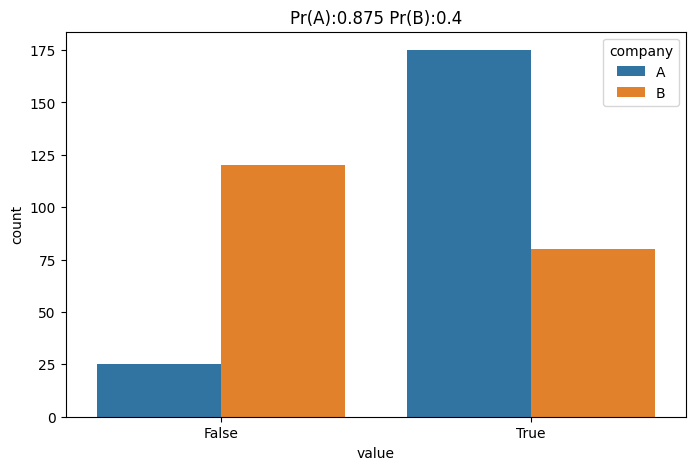

In [21]:
np.mean( A_causality)
np.mean( B_causality)

comb = A_causality + B_causality
data = {"company": ["A"]*steps + ["B"]*steps, "value": comb}
df = pd.DataFrame(data)


fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=df, x='value', hue='company')

ax.set_title('Pr(A):' +  str(np.mean( A_causality)) +
                " Pr(B):" + str(np.mean( B_causality))
                 )

plt.show()


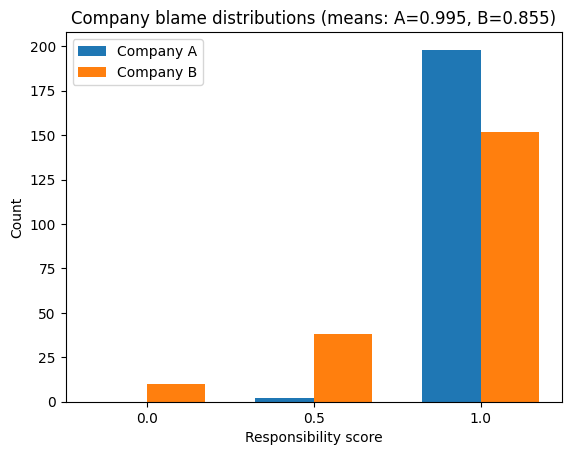

In [22]:
# despite the fact that uncertainties are expressed
# in terms of normal distributions
# the range of responsibility values is quite narrow
# because of the crude nature of the calculations
# which involve division by a the number of nodes

A_r_mean = np.mean(A_responsibility)
B_r_mean = np.mean(B_responsibility)

categories = np.unique(A_responsibility + B_responsibility)
A_counts = [A_responsibility.count(cat) for cat in categories]
B_counts = [B_responsibility.count(cat) for cat in categories]

bar_width = 0.35

bar_positions_A = np.arange(len(categories))
bar_positions_B = bar_positions_A + bar_width

plt.bar(bar_positions_A, A_counts, width=bar_width, label='Company A')
plt.bar(bar_positions_B, B_counts, width=bar_width, label='Company B')

plt.xlabel('Responsibility score')
plt.ylabel('Count')
plt.title('Company blame distributions (means: A=' + str(A_r_mean) + ', B=' + str(B_r_mean) + ')')

plt.xticks(bar_positions_A + bar_width / 2, categories)
plt.legend()

plt.show()
